In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
cd drive/MyDrive/

/content/drive/MyDrive


In [4]:
! pip install git+https://github.com/openai/whisper.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/openai/whisper.git to /tmp/pip-req-build-fo_3djh1
  Running command git clone --filter=blob:none --quiet https://github.com/openai/whisper.git /tmp/pip-req-build-fo_3djh1
  Resolved https://github.com/openai/whisper.git to commit 4e635c66441dfae3c6c72365f802293afffca3ef
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 85.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 99.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 24.9 MB/s eta 0:00:00
  Created wheel for openai-whisper: filename=openai_whisper-20230124-py3-none-any.whl size=1179331 sha256=5217a76e773dfb23d9672a4dfd52a5604e929e9ba314935f26215703bcf27cf3
  Stored in directory: /tmp/pip-ephem-wheel-cache-cirys5h9/wheels/a7/70/18/b7693c07b1d18b3dafb328f5d0496aa0d41a9c09ef332fd8e6
Successfully built opena

In [5]:
import io
import os
import numpy as np

try:
    import tensorflow  # required in Colab to avoid protobuf compatibility issues
except ImportError:
    pass

import torch
import pandas as pd
import urllib
import tarfile
import whisper
import torchaudio

from scipy.io import wavfile
from tqdm.notebook import tqdm


pd.options.display.max_rows = 100
pd.options.display.max_colwidth = 1000
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

**Loading the Fleurs dataset**

Select the language of the Fleur dataset to download. Please note that the transcription and translation performance varies widely depending on the language. Appendix D.2 in the paper contains the performance breakdown by language.

In [6]:
import ipywidgets as widgets

languages = {"af_za": "Afrikaans", "am_et": "Amharic", "ar_eg": "Arabic", "as_in": "Assamese", "az_az": "Azerbaijani", "be_by": "Belarusian", "bg_bg": "Bulgarian", "bn_in": "Bengali", "bs_ba": "Bosnian", "ca_es": "Catalan", "cmn_hans_cn": "Chinese", "cs_cz": "Czech", "cy_gb": "Welsh", "da_dk": "Danish", "de_de": "German", "el_gr": "Greek", "en_us": "English", "es_419": "Spanish", "et_ee": "Estonian", "fa_ir": "Persian", "fi_fi": "Finnish", "fil_ph": "Tagalog", "fr_fr": "French", "gl_es": "Galician", "gu_in": "Gujarati", "ha_ng": "Hausa", "he_il": "Hebrew", "hi_in": "Hindi", "hr_hr": "Croatian", "hu_hu": "Hungarian", "hy_am": "Armenian", "id_id": "Indonesian", "is_is": "Icelandic", "it_it": "Italian", "ja_jp": "Japanese", "jv_id": "Javanese", "ka_ge": "Georgian", "kk_kz": "Kazakh", "km_kh": "Khmer", "kn_in": "Kannada", "ko_kr": "Korean", "lb_lu": "Luxembourgish", "ln_cd": "Lingala", "lo_la": "Lao", "lt_lt": "Lithuanian", "lv_lv": "Latvian", "mi_nz": "Maori", "mk_mk": "Macedonian", "ml_in": "Malayalam", "mn_mn": "Mongolian", "mr_in": "Marathi", "ms_my": "Malay", "mt_mt": "Maltese", "my_mm": "Myanmar", "nb_no": "Norwegian", "ne_np": "Nepali", "nl_nl": "Dutch", "oc_fr": "Occitan", "pa_in": "Punjabi", "pl_pl": "Polish", "ps_af": "Pashto", "pt_br": "Portuguese", "ro_ro": "Romanian", "ru_ru": "Russian", "sd_in": "Sindhi", "sk_sk": "Slovak", "sl_si": "Slovenian", "sn_zw": "Shona", "so_so": "Somali", "sr_rs": "Serbian", "sv_se": "Swedish", "sw_ke": "Swahili", "ta_in": "Tamil", "te_in": "Telugu", "tg_tj": "Tajik", "th_th": "Thai", "tr_tr": "Turkish", "uk_ua": "Ukrainian", "ur_pk": "Urdu", "uz_uz": "Uzbek", "vi_vn": "Vietnamese", "yo_ng": "Yoruba"}
selection = widgets.Dropdown(
    options=[("Select language", None), ("----------", None)] + sorted([(f"{v} ({k})", k) for k, v in languages.items()]),
    value="ko_kr",
    description='Language:',
    disabled=False,
)

selection

Dropdown(description='Language:', index=39, options=(('Select language', None), ('----------', None), ('Afrika…

In [7]:
lang = selection.value
language = languages[lang]

assert lang is not None, "Please select a language"
print(f"Selected language: {language} ({lang})")

Selected language: Persian (fa_ir)


In [8]:
def download(url: str, target_path: str):
    with urllib.request.urlopen(url) as source, open(target_path, "wb") as output:
        with tqdm(total=int(source.info().get("Content-Length")), ncols=80, unit='iB', unit_scale=True, unit_divisor=1024) as loop:
            while True:
                buffer = source.read(8192)
                if not buffer:
                    break

                output.write(buffer)
                loop.update(len(buffer))


class Fleurs(torch.utils.data.Dataset):
    """
    A simple class to wrap Fleurs and subsample a portion of the dataset as needed.
    """
    def __init__(self, lang, split="test", subsample_rate=1, device=DEVICE):
        url = f"https://storage.googleapis.com/xtreme_translations/FLEURS102/{lang}.tar.gz"
        tar_path = os.path.expanduser(f"~/.cache/fleurs/{lang}.tgz")
        os.makedirs(os.path.dirname(tar_path), exist_ok=True)

        if not os.path.exists(tar_path):
            download(url, tar_path)

        all_audio = {}
        with tarfile.open(tar_path, "r:gz") as tar:
            for member in tar.getmembers():
                name = member.name
                if name.endswith(f"{split}.tsv"):
                    labels = pd.read_table(tar.extractfile(member), names=("id", "file_name", "raw_transcription", "transcription", "_", "num_samples", "gender"))

                if f"/{split}/" in name and name.endswith(".wav"):
                    audio_bytes = tar.extractfile(member).read()
                    all_audio[os.path.basename(name)] = wavfile.read(io.BytesIO(audio_bytes))[1]                    

        self.labels = labels.to_dict("records")[::subsample_rate]
        self.all_audio = all_audio
        self.device = device

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, item):
        record = self.labels[item]
        audio = torch.from_numpy(self.all_audio[record["file_name"]].copy())
        text = record["transcription"]
        
        return (audio, text)

In [9]:
dataset = Fleurs(lang, subsample_rate=10)  # subsample 10% of the dataset for a quick demo

  0%|                                              | 0.00/2.87G [00:00<?, ?iB/s]

**Running inference on the dataset using a medium Whisper model**

The following will take a few minutes to transcribe and translate utterances in the dataset.

In [10]:
model = whisper.load_model("medium")
print(
    f"Model is {'multilingual' if model.is_multilingual else 'English-only'} "
    f"and has {sum(np.prod(p.shape) for p in model.parameters()):,} parameters."
)

100%|█████████████████████████████████████| 1.42G/1.42G [00:19<00:00, 79.4MiB/s]


Model is multilingual and has 762,321,920 parameters.


In [11]:
options = dict(language=language, beam_size=5, best_of=5)
transcribe_options = dict(task="transcribe", **options)
translate_options = dict(task="translate", **options)

In [12]:
references = []
transcriptions = []
translations = []

for audio, text in tqdm(dataset):
    transcription = model.transcribe(audio, **transcribe_options)["text"]
    translation = model.transcribe(audio, **translate_options)["text"]
    
    transcriptions.append(transcription)
    translations.append(translation)
    references.append(text)

  0%|          | 0/88 [00:00<?, ?it/s]

In [13]:
data = pd.DataFrame(dict(reference=references, transcription=transcriptions, translation=translations))
data

,reference,transcription,translation
0,محققان دانشگاه پرینستون آمریکا و دانشگاه اوپسالا در سوئد گونه‌های جدید تکامل یافته‌ای را تنها در دو نسل گزارش دادند اگرچه اعتقاد بر این بود که به دلیل زاد و ولد بین یک سهره داروین بومی سهره زمینی متوسط و سهره کاکتوسی مهاجر یعنی سهره کاکتوسی بزرگ این روند خیلی بیشتر طول کشید,محاققان دانشگاه پرینستون امریکا و دانشگاه اوبسلا در سوید گنهای جدید تکمل یافتهی را تنها در دو نسل گزارش دادند. اگرچه اعتقاد بر این بود که به دلیل لذات و ولد بین یک سهره داروین بومی، سهره زمینی متوسط و سهره کاکتوسی مهاجر یعنی سهره کاکتوسی بزرگ، این روند خیلی بیشتر طول کشید. این بود که به دو نسل گزارش دادند.,"The researchers of Princeton University in the US and Uppsala University in Sweden only reported on two generations. Although it was believed that due to the relationship between a local Darwinian star, a medium-sized Earth star, and an immigrant Cactus star, this relationship lasted much longer."
1,چین باستان روش منحصربه‌فردی برای نشان دادن دوره‌های زمانی مختلف داشت هر دوره زمانی از چین یا هر خانواده که قدرت را در دست داشت یک سلسله متمایز بود,چین باستان روش منحسر بفردی برای نشان دادن دوره های زمانی مختلف داشت. هر دورهی زمانی از چین یا هر خانواده که قدرت را دردست داشت یک سلسلهی متمایز بود.,"China-Bastan had a unique tendency to show different times. Every time period in China, or every family that had the power, was a unique series."
2,نظرات ارسطو در مورد همه مسائل علمی از جمله روانشناسی پذیرفته شد,نظرات ارستو در مرد همه مسایل علمی از جملة ربانشناسی پذی رفته شد.,Aristotle's views on all scientific matters have been taken from the dictionary.
3,تفکیک و ترکیب مجدد اختلاف بین دو استخر با هر نسل را به سمت جلو و عقب بر می‌زند,تفکیک و ترکیب مجدد اختلاف بين دو استخ با هر نسر را به سمت جلو و اغب برمیزند.,Notification and recommendation of fighters will push the difference between two sides forward.
4,رمانتیسم عنصر عظیمی از جبرگرایی فرهنگی داشت که از نویسندگانی نظیر گوته فیشته و اشلگل نشأت گرفته بود,رومانتیسم انصور عظیمی از جبرگرای فرهنگی داشت، که از نویسندگانی نظیر گوته، فشته و اشلگل نشعت گرفته بود.,"Romanticism is a great element of cultural diversity, which was inspired by the writers Nazir Koté, Fichte and Eshelgel."
5,موساسور برترین شکارچی در دوره خود بود به همین خاطر از هیچ چیز نمی‌ترسید مگر سایر موساسورها,مساسور برطرین شکارچی در دوری خود بود. به همین خاطر از هیچیزی نمی ترسید مگر سایر مساسورها.,"Mosasor was the worst hunter in his time, so he was not afraid of anything but the rest of the Mosasors."
6,فرهنگهای کهن و قبایل شروع به نگهداری از آنها برای دسترسی آسان به شیر پشم گوشت و پوست کردند,فرهنگ های کهن و قبایل شروع به نگهداری از آنها برای دسترسی آسان به شیر، پشم، گشت و پست کرده.,"The culture of Kohan and Qabayel began to preserve them to make it easy to milk, feed, meat and skin."
7,اگر فیلم گنج ملی را تماشا کرده باشید ممکن است فکر کنید که یک نقشه گنج در پشت اعلامیه استقلال نوشته شده است,اگر فیم گنج ملی را تماشا کرده باشید ممکن از فکر کنید که یک نقصه گنج در پشت اعلامی استعلال نوشته شده است.,"If you have watched the film, you may think that a picture of a deer is written behind the scenes."
8,danielle lantagne کارشناس سازمان ملل متحد در زمینه این بیماری اظهار داشت احتمال می‌رود حافظان صلح باعث شیوع بیماری شده باشند,دنیل لانتاج کارشناس سازمان ملل متحد در زمین این بیماری اظهار داشت احتمال می راد حافظان سل باعث شروع بیماری شده باشند,"Daniel Lantage, a member of the United Nations on the ground of this disease, says it is likely that peacekeepers will be the cause of the disease."
9,آرواره های بلند آن با بیش از ۷۰ دندان به تیزی تیغ همراه با یک مجموعه اضافه در سقف دهانش پر شده بود و معنی آن این است که برای هر چیزی که از مسیر آن عبور کند فراری وجود ندارد,آرواره های بلند اون با بیش از هفتاد دندان به تیزی تیغ همراه با یک مجموعه اضافه در سخف دهانش بر شده بود. و معنی اون این هست که برای هر چیزی که از مسیر اون عبور کند فراری وجود ندارد.,"With more than 70 teeth, it was filled with the speed of an arrow, along with an additional group in its mouth. And its meaning is that there is no escape for anything that crosses its path."


**Word-level timestamps using attention weights**


Below, we use the cross-attention weights to determine more granular, word-level timestamps. It uses a set of heuristics and dynamic time warping (DTW) to find the alignment between the audio and the transcript.

In [14]:
! pip install dtw-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 661.4/661.4 KB 24.7 MB/s eta 0:00:00


In [15]:
import string
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib.ticker as ticker

from IPython.display import display, HTML
from whisper.tokenizer import get_tokenizer
from dtw import dtw
from scipy.ndimage import median_filter

%matplotlib inline
%config InlineBackend.figure_format = "retina"

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [16]:
AUDIO_SAMPLES_PER_TOKEN = whisper.audio.HOP_LENGTH * 2
AUDIO_TIME_PER_TOKEN = AUDIO_SAMPLES_PER_TOKEN / whisper.audio.SAMPLE_RATE

medfilt_width = 7
qk_scale = 1.0

tokenizer = get_tokenizer(model.is_multilingual, language=languages[lang])

In [17]:
# This part downloads a repackaged version of the Noto Sans font (either CJK or non-CJK)
# to render various languages in Matplotlib figures.

if languages[lang] in {"Chinese", "Japanese", "Korean"}:
    font = "GoNotoCJKCore.ttf"
else:
    font = "GoNotoCurrent.ttf"

font_release = "https://github.com/satbyy/go-noto-universal/releases/download/v5.2"
if not os.path.exists(font):
    download(f"{font_release}/{font}", font)

prop = fm.FontProperties(fname=font)
props = {'fontproperties': prop}

In [18]:
def split_tokens_on_unicode(tokens: torch.Tensor):
    words = []
    word_tokens = []
    current_tokens = []
    
    for token in tokens.tolist():
        current_tokens.append(token)
        decoded = tokenizer.decode_with_timestamps(current_tokens)
        if "\ufffd" not in decoded:
            words.append(decoded)
            word_tokens.append(current_tokens)
            current_tokens = []
    
    return words, word_tokens

In [19]:
def split_tokens_on_spaces(tokens: torch.Tensor):
    subwords, subword_tokens_list = split_tokens_on_unicode(tokens)
    words = []
    word_tokens = []
    
    for subword, subword_tokens in zip(subwords, subword_tokens_list):
        special = subword_tokens[0] >= tokenizer.eot
        with_space = subword.startswith(" ")
        punctuation = subword.strip() in string.punctuation
        if special or with_space or punctuation:
            words.append(subword)
            word_tokens.append(subword_tokens)
        else:
            words[-1] = words[-1] + subword
            word_tokens[-1].extend(subword_tokens)
    
    return words, word_tokens

In [20]:
if languages[lang] in {"Chinese", "Japanese", "Thai", "Lao", "Myanmar"}:
    # These languages don't typically use spaces, so it is difficult to split words
    # without morpheme analysis. Here, we instead split words at any
    # position where the tokens are decoded as valid unicode points
    split_tokens = split_tokens_on_unicode
else:
    split_tokens = split_tokens_on_spaces

In [21]:
# install hooks on the cross attention layers to retrieve the attention weights
QKs = [None] * model.dims.n_text_layer

for i, block in enumerate(model.decoder.blocks):
    block.cross_attn.register_forward_hook(
        lambda _, ins, outs, index=i: QKs.__setitem__(index, outs[-1])
    )

In [21]:
!pip  install   torch==1.8.0+cu111 torchvision==0.9.0+cu111 torchaudio==0.8.0 -f https://download.pytorch.org/whl/torch_stable.html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 2.0/2.0 GB 140.1 MB/s eta 0:00:01tcmalloc: large alloc 1982242816 bytes == 0x4022000 @  0x7f9122d5c680 0x7f9122d7d824 0x5b3128 0x5bbc90 0x5f714c 0x64d800 0x527022 0x504866 0x56bbe1 0x569d8a 0x5f60c3 0x56bbe1 0x569d8a 0x5f60c3 0x56bbe1 0x569d8a 0x5f60c3 0x56bbe1 0x569d8a 0x5f60c3 0x56bbe1 0x569d8a 0x5f60c3 0x56bbe1 0x5f5ee6 0x56bbe1 0x569d8a 0x5f60c3 0x56cc92 0x569d8a 0x5f60c3
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 2.0/2.0 GB 149.2 MB/s eta 0:00:01tcmalloc: large alloc 2477809664 bytes == 0x7a28c000 @  0x7f9122d5c680 0x7f9122d7cda2 0x5f714c 0x64d800 0x527022 0x504866 0x56bbe1 0x569d8a 0x5f60c3 0x56bbe1 0x569d8a 0x5f60c3 0x56bbe1 0x569d8a 0x5f60c3 0x56bbe1 0x569d8a 0x5f60c3 0x56bbe1 0x569d8a 0x5f60c3 0x56bbe1 0x5f5ee6 0x56bbe1 0x569d8a 0x5f60c3 0x56cc92 0x569d8a 0x5f60c3

 محاققان دانشگاه پرینستون امریکا و دانشگاه اوبسلا در سوید گنهای جدید تکمل یافتهی را تنها در دو نسل گزارش دادند. اگرچه اعتقاد بر این بود که به دلیل لذات و ولد بین یک سهره داروین بومی، سهره زمینی متوسط و سهره کاکتوسی مهاجر یعنی سهره کاکتوسی بزرگ، این روند خیلی بیشتر طول کشید. این بود که به دو نسل گزارش دادند.


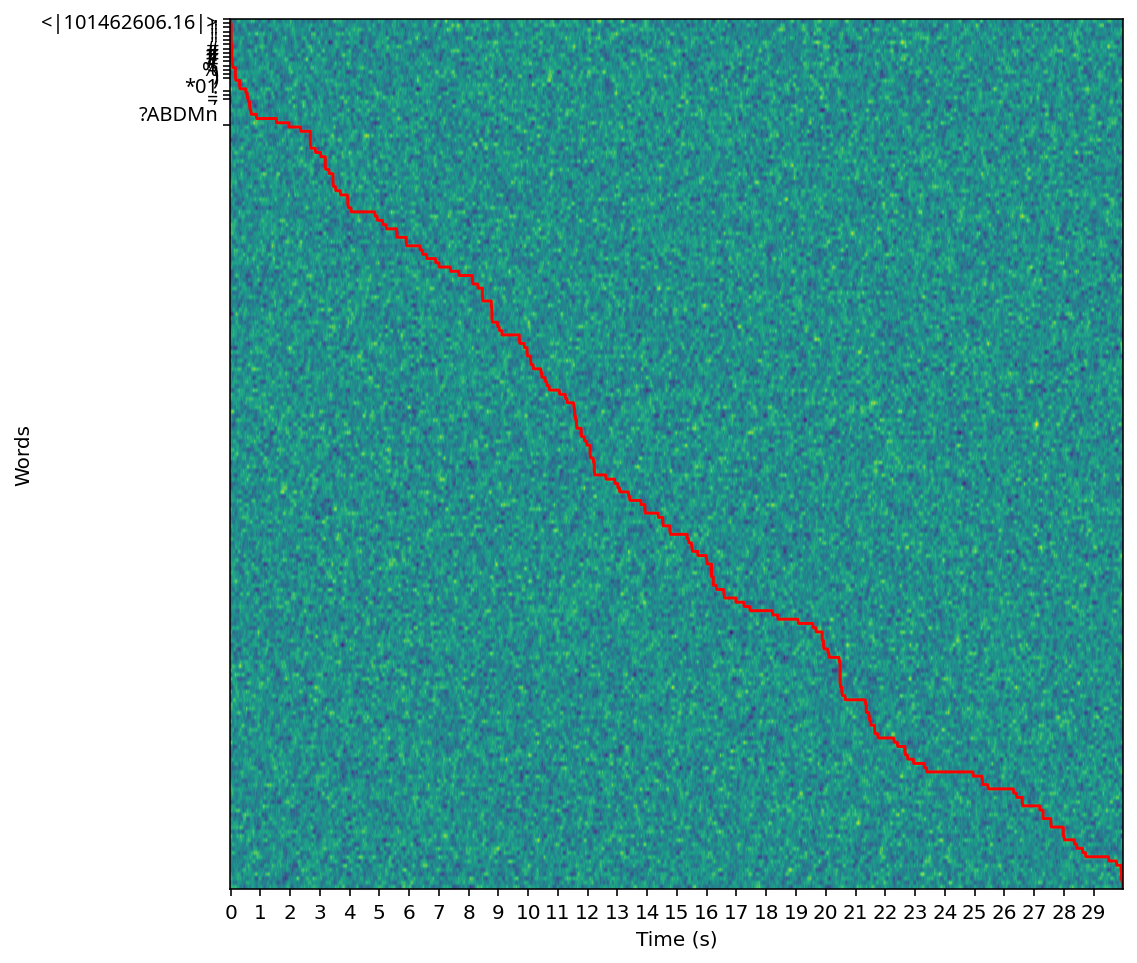

,word,begin,end
0,"""",0.02,0.02
1,"""",0.02,0.02
2,"""",0.02,0.02
3,"""",0.02,0.02
4,"""",0.02,0.04
5,#,0.04,0.04
6,#,0.04,0.04
7,#,0.04,0.04
8,#,0.04,0.06
9,$,0.06,0.08


 چین باستان روش منحسر بفردی برای نشان دادن دوره های زمانی مختلف داشت. هر دورهی زمانی از چین یا هر خانواده که قدرت را دردست داشت یک سلسلهی متمایز بود.


RuntimeError: ignored

In [22]:
# for the first 10 examples in the dataset


for (audio, label), transcription in zip(dataset, transcriptions[:10]):
    print(transcription)
  
    duration = len(audio)
    mel = whisper.log_mel_spectrogram(whisper.pad_or_trim(audio)).cuda()
    tokens = torch.tensor(
        [
            *tokenizer.sot_sequence,
            tokenizer.timestamp_begin,
        ] + tokenizer.encode(transcription) + [
            tokenizer.timestamp_begin + duration // AUDIO_SAMPLES_PER_TOKEN,
            tokenizer.eot,
        ]
    ).cuda()
    with torch.no_grad():
        logits = model(mel.unsqueeze(0), tokens.unsqueeze(0))

    weights = torch.cat(QKs)  # layers * heads * tokens * frames    
    weights = weights[:, :, :, : duration // AUDIO_SAMPLES_PER_TOKEN].cpu()
    weights = median_filter(weights, (1, 1, 1, medfilt_width))
    weights = torch.tensor(weights * qk_scale).softmax(dim=-1)
    
    w = weights / weights.norm(dim=-2, keepdim=True)
    matrix = w[-6:].mean(axis=(0, 1))

    alignment = dtw(-matrix.double().numpy())

    jumps = np.pad(np.diff(alignment.index1s), (1, 0), constant_values=1).astype(bool)
    jump_times = alignment.index2s[jumps] * AUDIO_TIME_PER_TOKEN
    words, word_tokens = split_tokens(tokens)

    # display the normalized attention weights and the alignment
    plt.figure(figsize=(8, 8))
    plt.imshow(matrix, aspect="auto")
    plt.plot(alignment.index2s, alignment.index1s, color="red")

    xticks = np.arange(0, matrix.shape[1], 1 / AUDIO_TIME_PER_TOKEN)
    xticklabels = (xticks * AUDIO_TIME_PER_TOKEN).round().astype(np.int32) 
    plt.xticks(xticks, xticklabels)
    plt.xlabel("Time (s)")
    
    # display tokens and words as tick labels
    ylims = plt.gca().get_ylim()

    ax = plt.gca()
    ax.tick_params('both', length=0, width=0, which='minor', pad=6)

    ax.yaxis.set_ticks_position("left")
    ax.yaxis.set_label_position("left")
    ax.invert_yaxis()
    ax.set_ylim(ylims)

    major_ticks = [-0.5]
    minor_ticks = []
    current_y = 0
    
    for word, word_token in zip(words, word_tokens):
        minor_ticks.append(current_y + len(word_token) / 2 - 0.5)
        current_y += len(word_token)
        major_ticks.append(current_y - 0.5)
        
    ax.yaxis.set_minor_locator(ticker.FixedLocator(minor_ticks))
    ax.yaxis.set_minor_formatter(ticker.FixedFormatter(words))
    ax.set_yticks(major_ticks)
    ax.yaxis.set_major_formatter(ticker.NullFormatter())
    
    for label in ax.get_yminorticklabels():
        label.set_fontproperties(prop)

    plt.ylabel("Words")
    plt.show()

    # display the word-level timestamps in a table
    word_boundaries = np.pad(np.cumsum([len(t) for t in word_tokens[:-1]]), (1, 0))
    begin_times = jump_times[word_boundaries[:-1]]
    end_times = jump_times[word_boundaries[1:]]

    data = [
        dict(word=word, begin=begin, end=end)
        for word, begin, end in zip(words[:-1], begin_times, end_times)
        if not word.startswith("<|") and word.strip() not in ".,!?、。"
    ]

    display(pd.DataFrame(data))
    display(HTML("<hr>"))